In [1]:
import pandas as pd
import numpy as np
import sys
import lifelines

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
import statsmodels.stats.multitest as multi
from matplotlib.collections import PatchCollection
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [22]:
def make_df(surv,surv_type,raw):
    #get survival dataframe
    surv=pd.read_csv(surv,index_col=0)
    surv=surv.rename(columns={"bcr_patient_barcode":"FID"})
    #get genotypes
    snps=pd.read_csv(raw,delimiter=" ")
    cols=[x for x in snps.columns if x not in ["IID","PAT","MAT","SEX","PHENOTYPE"]]
    snps=snps[cols]
    #combine dataframes
    full_surv=pd.merge(surv[["FID",surv_type,surv_type+".time"]],snps,on="FID")
    print(full_surv.shape)
    full_surv=full_surv[full_surv[surv_type+".time"]<1825]
    return(full_surv)

In [23]:
os_surv=make_df("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","OS","/cellar/users/sgoudarzi/cancer_meqtls_clumped.raw")

(8183, 274)


In [2]:
test = pd.read_csv("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv")
test

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,1,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,2,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,3,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,4,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,5,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11155,11156,TCGA-YZ-A980,UVM,75.0,MALE,WHITE,Stage IIIA,Stage IIIA,Spindle Cell|Epithelioid Cell,[Not Available],...,NaN,0.0,1862.0,0.0,1862.0,NaN,NaN,1.0,1556.0,NaN
11156,11157,TCGA-YZ-A982,UVM,79.0,FEMALE,WHITE,Stage IIIB,Stage IIIB,Spindle Cell,[Not Available],...,NaN,0.0,495.0,0.0,495.0,NaN,NaN,0.0,495.0,NaN
11157,11158,TCGA-YZ-A983,UVM,51.0,FEMALE,WHITE,Stage IIB,Stage IIB,Epithelioid Cell,[Not Available],...,NaN,0.0,798.0,0.0,798.0,NaN,NaN,0.0,798.0,NaN
11158,11159,TCGA-YZ-A984,UVM,50.0,FEMALE,WHITE,Stage IIB,Stage IIIA,Spindle Cell|Epithelioid Cell,[Not Available],...,NaN,1.0,1396.0,1.0,1396.0,NaN,NaN,1.0,154.0,NaN


In [24]:
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp_canc = canc.set_index(2)[0].to_dict()
os_surv["cancer"]=os_surv["FID"].map(mp_canc)

In [25]:
rsid_lst=os_surv.columns[3:-1]

In [26]:
cancers=os_surv["cancer"].unique().tolist()
print("conducting survival analysis with {0} variants and {1} cancers".format(len(rsid_lst),len(cancers)))

conducting survival analysis with 271 variants and 30 cancers


In [27]:
def run_surv(df,surv_type,rsid,cancers):
    snp=[]
    logrank=[]
    cancer=[]
    min_group=[]
    maj_group=[]

    for y in cancers:
        for x in rsid:
            try:
                full_surv_canc=df[df["cancer"]==y]
            
                rs=x.rsplit(":",2)[0]
                allele=x.split(":")[3]
                minor=allele.split("_")[1]
                major=allele.split("_")[0]
            
                groups = full_surv_canc[x]
                ix0 = (groups == 0)
                ix1 = (groups == 1)
                ix2 = (groups == 2)

                results = logrank_test(full_surv_canc[surv_type+'.time'][ix0], full_surv_canc[surv_type+'.time'][ix2],event_observed_A=full_surv_canc[surv_type][ix0], event_observed_B=full_surv_canc[surv_type][ix2], alpha=.95) 
        
                snp.append(x)
                logrank.append(results.p_value)
                cancer.append(y)
                min_group.append(len(full_surv_canc[surv_type+'.time'][ix2]))
                maj_group.append(len(full_surv_canc[surv_type+'.time'][ix0]))
        
            except:
                pass
        
    os=pd.DataFrame({"snps":snp,"logrank":logrank,"cancer":cancer,"min":min_group,"maj":maj_group})
    return(os)

In [28]:
os=run_surv(os_surv,"OS",rsid_lst,cancers)

In [29]:
os = os.rename(columns={"logrank":"os.time"})

In [11]:
os[os["snps"].str.contains("1:15817334:G:A")].sort_values(by="os.time")

,snps,os.time,cancer,min,maj
12942,1:15817334:G:A_A,0.002991,SARC,24,80
14706,1:15817334:G:A_A,0.008689,TGCT,9,34
6,1:15817334:G:A_A,0.054035,ACC,5,27
17058,1:15817334:G:A_A,0.110935,UVM,9,32
5886,1:15817334:G:A_A,0.180712,KIRC,24,140
10590,1:15817334:G:A_A,0.181455,PAAD,15,54
10002,1:15817334:G:A_A,0.218569,OV,37,185
15294,1:15817334:G:A_A,0.220034,THCA,18,141
1770,1:15817334:G:A_A,0.250809,CESC,10,76
6474,1:15817334:G:A_A,0.296705,KIRP,10,85


In [30]:
os["sum"]=os["min"]+os["maj"]
os["freq"]=os["min"]/os["sum"]
os_filt=os[(os["freq"]>.01)&(os["min"]>1)]

In [31]:
def fdr(df,P):
    probabilities = df[P].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

In [32]:
os_fdr=pd.DataFrame()

for x in os_filt["cancer"].unique().tolist():
    os_cancer=os_filt[os_filt["cancer"]==x]
    os_cancer=os_cancer[~os_cancer["os.time"].isnull()]
    os_fdr=os_fdr.append(fdr(os_cancer,"os.time"))

In [33]:
os_sig=os_fdr[os_fdr["-log10(fdr)"]>1]
os_sig["snps"]=os_sig["snps"].str.split("_").str[0]

<ipython-input-33-f2d4703764c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_sig["snps"]=os_sig["snps"].str.split("_").str[0]


In [34]:
os_sig.head()

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr)
97,5:56085225:C:T,5.347613e-04,ACC,2,35,37,0.054054,0.041979,1.376970
136,9:10389328:G:C,3.804565e-04,ACC,3,32,35,0.085714,0.041979,1.376970
287,1:150913257:C:T,2.715419e-04,BLCA,3,243,246,0.012195,0.026883,1.570528
373,5:112139424:A:G,5.112412e-07,BLCA,9,203,212,0.042453,0.000101,3.994709
545,1:15914135:A:G,1.541492e-04,BRCA,11,462,473,0.023256,0.016186,1.790869


In [35]:
os_sig.to_csv("/cellar/users/sgoudarzi/os_clumped_significant_meqtls.csv")

In [38]:
os_sig = pd.read_csv("/cellar/users/sgoudarzi/os_clumped_significant_meqtls.csv")
del os_sig["Unnamed: 0"]
os_sig = os_sig.drop_duplicates(subset=["snps"])
os_sig = os_sig.reset_index(drop=True)
os_sig

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr)
0,5:56085225:C:T,5.347613e-04,ACC,2,35,37,0.054054,4.197876e-02,1.376970
1,9:10389328:G:C,3.804565e-04,ACC,3,32,35,0.085714,4.197876e-02,1.376970
2,1:150913257:C:T,2.715419e-04,BLCA,3,243,246,0.012195,2.688265e-02,1.570528
3,5:112139424:A:G,5.112412e-07,BLCA,9,203,212,0.042453,1.012258e-04,3.994709
4,1:15914135:A:G,1.541492e-04,BRCA,11,462,473,0.023256,1.618567e-02,1.790869
5,10:72723176:G:A,1.060316e-06,BRCA,13,453,466,0.027897,2.226665e-04,3.652345
6,12:116063437:A:T,6.999786e-06,CESC,5,104,109,0.045872,1.329959e-03,2.876162
7,3:53766284:G:A,2.300484e-06,COAD,3,247,250,0.012000,2.323489e-04,3.633859
8,9:8871342:G:C,4.472957e-12,COAD,3,244,247,0.012146,9.035373e-10,9.044054
9,7:5584599:G:A,6.152483e-05,KIRC,53,117,170,0.311765,6.152483e-03,2.210950


In [37]:
print(len(pd.unique(os_sig["snps"])))

56


In [18]:
associations = pd.read_csv("/cellar/users/sgoudarzi/python_scripts/compile_plink/unique_significant_meqtls_assoc.txt", delim_whitespace=True)
#CHROM  POS     ID      REF     ALT     A1      TEST    OBS_CT  BETA    SE      T_STAT  P       ERRCODE      Unnamed: 0      gene
#associations = associations.rename(columns={0:"chr", 1:"bp", 2:"snps", 3:"ref", 4:"alt", 5:"A1", 6:"test", 8:"beta", 9:"se", 10:"t_stat", 11:"p-value", 14:"file"})
associations = associations.rename(columns={"SNP":"snps"})
associations

,CHROM,POS,snps,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,Unnamed:,0,gene
0,16,89774396,16:89774396:A:G,A,G,G,ADD,6912,0.094887,0.017024,5.57363,2.589090e-08,.,1627,FANCA,NaN
1,16,89775946,16:89775946:A:G,A,G,G,ADD,6912,0.106956,0.017048,6.27365,3.740150e-10,.,1562,FANCA,NaN
2,16,89790167,16:89790167:G:C,G,C,C,ADD,6912,0.116260,0.017197,6.76055,1.487210e-11,.,3486,FANCA,NaN
3,16,89792228,16:89792228:T:C,T,C,C,ADD,6912,0.116549,0.017150,6.79594,1.165980e-11,.,3483,FANCA,NaN
4,16,89793042,16:89793042:G:T,G,T,T,ADD,6912,0.114474,0.017193,6.65830,2.983110e-11,.,3484,FANCA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2,47762216,2:47762216:T:G,T,G,G,ADD,6912,0.126953,0.023331,5.44134,5.469980e-08,.,3303,MSH2,NaN
584,2,47766607,2:47766607:G:T,G,T,T,ADD,6912,0.129348,0.023171,5.58239,2.462600e-08,.,3322,MSH2,NaN
585,2,47766835,2:47766835:G:C,G,C,C,ADD,6912,0.110280,0.021719,5.07751,3.924440e-07,.,3328,MSH2,NaN
586,2,47768786,2:47768786:C:T,C,T,T,ADD,6912,0.147537,0.025053,5.88886,4.071300e-09,.,2167,MSH2,NaN


In [17]:
len(pd.unique(associations["SNP"]))

588

In [18]:
assoc_short = associations[["snps", "file", "beta", "p-value"]]

In [19]:
os_sig_assoc = pd.merge(os_sig, assoc_short, on="snps", how="left")
os_sig_assoc

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr),file,beta,p-value
0,1:15914135:A:G,0.000154,BRCA,11,462,473,0.023256,0.085245,1.069334,CASP9,0.203680,2.425760e-16
1,1:15914135:A:G,0.000011,KIRC,5,221,226,0.022124,0.006083,2.215868,CASP9,0.203680,2.425760e-16
2,10:88648672:G:A,0.017260,LUSC,13,226,239,0.054393,0.079167,1.101458,BMPR1A,-0.096126,2.045360e-06
3,10:88660199:G:A,0.017448,LUSC,13,227,240,0.054167,0.079167,1.101458,BMPR1A,-0.095848,2.145120e-06
4,10:104225832:T:C,0.016637,LUSC,48,144,192,0.250000,0.078068,1.107528,SUFU,0.083221,3.524160e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
326,1:15914012:G:A,0.008689,TGCT,9,34,43,0.209302,0.082549,1.083290,CASP9,0.259912,5.182620e-46
327,1:15914078:A:G,0.010043,TGCT,9,33,42,0.214286,0.091876,1.036800,CASP9,0.255191,1.280690e-44
328,1:15914135:A:G,0.000355,TGCT,2,45,47,0.042553,0.082549,1.083290,CASP9,0.203680,2.425760e-16
329,1:15914545:C:T,0.008689,TGCT,9,34,43,0.209302,0.082549,1.083290,CASP9,0.259676,6.172840e-46


In [38]:
os_sig_assoc.to_csv("/cellar/users/sgoudarzi/kaplan-meier/meqtl_os_association.csv")

In [2]:
os_sig_assoc = pd.read_csv("/cellar/users/sgoudarzi/kaplan-meier/meqtl_os_association.csv")
os_sig_assoc

,Unnamed: 0,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr),file,beta,p-value
0,0,1:15914135:A:G,0.000154,BRCA,11,462,473,0.023256,0.085245,1.069334,CASP9,0.203680,2.425760e-16
1,1,1:15914135:A:G,0.000011,KIRC,5,221,226,0.022124,0.006083,2.215868,CASP9,0.203680,2.425760e-16
2,2,10:88648672:G:A,0.017260,LUSC,13,226,239,0.054393,0.079167,1.101458,BMPR1A,-0.096126,2.045360e-06
3,3,10:88660199:G:A,0.017448,LUSC,13,227,240,0.054167,0.079167,1.101458,BMPR1A,-0.095848,2.145120e-06
4,4,10:104225832:T:C,0.016637,LUSC,48,144,192,0.250000,0.078068,1.107528,SUFU,0.083221,3.524160e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,326,1:15914012:G:A,0.008689,TGCT,9,34,43,0.209302,0.082549,1.083290,CASP9,0.259912,5.182620e-46
327,327,1:15914078:A:G,0.010043,TGCT,9,33,42,0.214286,0.091876,1.036800,CASP9,0.255191,1.280690e-44
328,328,1:15914135:A:G,0.000355,TGCT,2,45,47,0.042553,0.082549,1.083290,CASP9,0.203680,2.425760e-16
329,329,1:15914545:C:T,0.008689,TGCT,9,34,43,0.209302,0.082549,1.083290,CASP9,0.259676,6.172840e-46


In [6]:
unique_os_meqtls = os_sig_assoc.drop_duplicates(subset=["snps"])
unique_os_meqtls = unique_os_meqtls.reset_index(drop=True)
unique_os_meqtls

,Unnamed: 0,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr),file,beta,p-value
0,0,1:15914135:A:G,0.000154,BRCA,11,462,473,0.023256,0.085245,1.069334,CASP9,0.203680,2.425760e-16
1,2,10:88648672:G:A,0.017260,LUSC,13,226,239,0.054393,0.079167,1.101458,BMPR1A,-0.096126,2.045360e-06
2,3,10:88660199:G:A,0.017448,LUSC,13,227,240,0.054167,0.079167,1.101458,BMPR1A,-0.095848,2.145120e-06
3,4,10:104225832:T:C,0.016637,LUSC,48,144,192,0.250000,0.078068,1.107528,SUFU,0.083221,3.524160e-06
4,5,10:104225837:T:G,0.016637,LUSC,48,144,192,0.250000,0.078068,1.107528,SUFU,0.083221,3.524160e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,271,15:50755396:C:T,0.000559,SKCM,16,184,200,0.080000,0.055040,1.259321,USP8,-0.125879,1.559190e-09
269,277,1:15808198:C:T,0.003129,TGCT,7,36,43,0.162791,0.082549,1.083290,CASP9,0.237308,8.303660e-34
270,278,1:15808702:C:T,0.003129,TGCT,7,36,43,0.162791,0.082549,1.083290,CASP9,0.238173,4.017700e-34
271,279,1:15808872:G:A,0.003129,TGCT,7,36,43,0.162791,0.082549,1.083290,CASP9,0.238173,4.017700e-34


In [39]:
meqtls = pd.read_csv("meqtls_tads.csv")
meqtl_short = pd.DataFrame()
snps = []
tads = []
for i, row in meqtls.iterrows():
    l = row["SNP"].split(":")
    snps.append(l[0]+":"+l[1]+":"+l[2]+":"+l[3])
    snps.append(l[0]+":"+l[1]+":"+l[3]+":"+l[2])
    tads.append(row["TAD Type"])
    tads.append(row["TAD Type"])
meqtl_short["snps"] = snps
meqtl_short["TAD_TYPE"] = tads
meqtl_short

,snps,TAD_TYPE
0,2:33952621:G:A,Boundary
1,2:33952621:A:G,Boundary
2,2:33954560:C:T,Boundary
3,2:33954560:T:C,Boundary
4,2:33953186:C:T,Boundary
...,...,...
2472279,10:2018353:T:C,Neither
2472280,10:2019373:C:T,Neither
2472281,10:2019373:T:C,Neither
2472282,10:79931884:C:T,Boundary


In [40]:
os_sig = pd.merge(os_sig, meqtl_short, on="snps")
os_sig

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr),TAD_TYPE
0,5:56085225:C:T,5.347613e-04,ACC,2,35,37,0.054054,4.197876e-02,1.376970,Inactive
1,9:10389328:G:C,3.804565e-04,ACC,3,32,35,0.085714,4.197876e-02,1.376970,Boundary
2,1:150913257:C:T,2.715419e-04,BLCA,3,243,246,0.012195,2.688265e-02,1.570528,Active
3,5:112139424:A:G,5.112412e-07,BLCA,9,203,212,0.042453,1.012258e-04,3.994709,Boundary
4,1:15914135:A:G,1.541492e-04,BRCA,11,462,473,0.023256,1.618567e-02,1.790869,Active
5,10:72723176:G:A,1.060316e-06,BRCA,13,453,466,0.027897,2.226665e-04,3.652345,Inactive
6,12:116063437:A:T,6.999786e-06,CESC,5,104,109,0.045872,1.329959e-03,2.876162,Boundary
7,3:53766284:G:A,2.300484e-06,COAD,3,247,250,0.012000,2.323489e-04,3.633859,Boundary
8,9:8871342:G:C,4.472957e-12,COAD,3,244,247,0.012146,9.035373e-10,9.044054,Boundary
9,7:5584599:G:A,6.152483e-05,KIRC,53,117,170,0.311765,6.152483e-03,2.210950,Active


In [41]:
os_sig["TAD_TYPE"].value_counts()

Boundary    34
Inactive    10
Active       6
Mixed        3
Neither      3
Name: TAD_TYPE, dtype: int64

In [8]:
unique_os_meqtls = pd.merge(unique_os_meqtls, meqtl_short, on="snps")
unique_os_meqtls

,Unnamed: 0,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr),file,beta,p-value,TAD_TYPE
0,0,1:15914135:A:G,0.000154,BRCA,11,462,473,0.023256,0.085245,1.069334,CASP9,0.203680,2.425760e-16,Active
1,2,10:88648672:G:A,0.017260,LUSC,13,226,239,0.054393,0.079167,1.101458,BMPR1A,-0.096126,2.045360e-06,Active
2,3,10:88660199:G:A,0.017448,LUSC,13,227,240,0.054167,0.079167,1.101458,BMPR1A,-0.095848,2.145120e-06,Active
3,4,10:104225832:T:C,0.016637,LUSC,48,144,192,0.250000,0.078068,1.107528,SUFU,0.083221,3.524160e-06,Boundary
4,5,10:104225837:T:G,0.016637,LUSC,48,144,192,0.250000,0.078068,1.107528,SUFU,0.083221,3.524160e-06,Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,271,15:50755396:C:T,0.000559,SKCM,16,184,200,0.080000,0.055040,1.259321,USP8,-0.125879,1.559190e-09,Boundary
269,277,1:15808198:C:T,0.003129,TGCT,7,36,43,0.162791,0.082549,1.083290,CASP9,0.237308,8.303660e-34,Boundary
270,278,1:15808702:C:T,0.003129,TGCT,7,36,43,0.162791,0.082549,1.083290,CASP9,0.238173,4.017700e-34,Boundary
271,279,1:15808872:G:A,0.003129,TGCT,7,36,43,0.162791,0.082549,1.083290,CASP9,0.238173,4.017700e-34,Boundary


In [9]:
unique_os_meqtls["TAD_TYPE"].value_counts()

Boundary    238
Active       34
Mixed         1
Name: TAD_TYPE, dtype: int64

In [19]:
associations = pd.merge(associations, meqtl_short, on="snps")
associations

,CHROM,POS,snps,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,Unnamed:,0,gene,TAD_TYPE
0,16,89774396,16:89774396:A:G,A,G,G,ADD,6912,0.094887,0.017024,5.57363,2.589090e-08,.,1627,FANCA,NaN,Active
1,16,89775946,16:89775946:A:G,A,G,G,ADD,6912,0.106956,0.017048,6.27365,3.740150e-10,.,1562,FANCA,NaN,Active
2,16,89790167,16:89790167:G:C,G,C,C,ADD,6912,0.116260,0.017197,6.76055,1.487210e-11,.,3486,FANCA,NaN,Active
3,16,89792228,16:89792228:T:C,T,C,C,ADD,6912,0.116549,0.017150,6.79594,1.165980e-11,.,3483,FANCA,NaN,Active
4,16,89793042,16:89793042:G:T,G,T,T,ADD,6912,0.114474,0.017193,6.65830,2.983110e-11,.,3484,FANCA,NaN,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2,47762216,2:47762216:T:G,T,G,G,ADD,6912,0.126953,0.023331,5.44134,5.469980e-08,.,3303,MSH2,NaN,Mixed
584,2,47766607,2:47766607:G:T,G,T,T,ADD,6912,0.129348,0.023171,5.58239,2.462600e-08,.,3322,MSH2,NaN,Mixed
585,2,47766835,2:47766835:G:C,G,C,C,ADD,6912,0.110280,0.021719,5.07751,3.924440e-07,.,3328,MSH2,NaN,Mixed
586,2,47768786,2:47768786:C:T,C,T,T,ADD,6912,0.147537,0.025053,5.88886,4.071300e-09,.,2167,MSH2,NaN,Mixed


In [20]:
associations["TAD_TYPE"].value_counts()

Boundary    362
Active      210
Mixed        15
Inactive      1
Name: TAD_TYPE, dtype: int64

In [42]:
def run_surv_plot(df_annot,surv_df,surv_type,out):
    for i,row in df_annot.iterrows():
        try:
            surv_df_canc=surv_df[surv_df["cancer"]==row["cancer"]]
            x=[x for x in surv_df.columns if row["snps"] in x][0]
            rs=x.rsplit(":",2)[0]
        
            allele1=x.split(":")[2]
            allele2=str(x.split("_")[0]).split(":")[3]
            minor=x.split("_")[1]
            if allele1 == minor:
                major=allele2
            else:
                major=allele1
            
            fig=plt.figure(figsize=(12,5))
            ax1 = plt.subplot(1,2,1)
            
            groups = surv_df_canc[x]
            ix0 = (groups == 0)
            ix1 = (groups == 1)
            ix2 = (groups == 2)

            kmf = KaplanMeierFitter()
            kmf.fit(surv_df_canc[surv_type+'.time'][ix2], surv_df_canc[surv_type][ix2],label=minor+minor)
            kmf.plot(color='green', ci_show=False, ax=ax1)
            
            kmf.fit(surv_df_canc[surv_type+'.time'][ix1], surv_df_canc[surv_type][ix1],label=major+minor)
            kmf.plot(ax=ax1, color='orange', ci_show=False)
    
            kmf.fit(surv_df_canc[surv_type+'.time'][ix0], surv_df_canc[surv_type][ix0],label=major+major)
            kmf.plot(ax=ax1, color='blue', ci_show=False)

            results = logrank_test(surv_df_canc[surv_type+'.time'][ix0], surv_df_canc[surv_type+'.time'][ix2],event_observed_A=surv_df_canc[surv_type][ix0], event_observed_B=surv_df_canc[surv_type][ix2], alpha=.95) 
            plt.title('{}.{}\n{}\nLog-rank test: p<{:.3}'.format(x,row["file"],row["cancer"],results.p_value))

            plt.xlabel('Months')
            plt.ylabel(surv_type+' time (days)')
            plt.legend(frameon=False)

            plt.tight_layout()

            plt.savefig(out+surv_type+"."+x+'.'+row["file"]+"."+row["cancer"]+'.pdf')
            plt.close()
        
        except:
            pass

In [21]:
run_surv_plot(os_sig_assoc,os_surv,"OS","/cellar/users/sgoudarzi/kaplan-meier/plots/clumped_meqtls/")

In [43]:
pfi_surv=make_df("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","PFI","/cellar/users/sgoudarzi/cancer_meqtls_clumped.raw")

(8183, 274)


In [44]:
pfi_surv["cancer"]=pfi_surv["FID"].map(mp_canc)

In [45]:
pfi=run_surv(pfi_surv,"PFI",rsid_lst,cancers)

In [46]:
pfi["sum"]=pfi["min"]+pfi["maj"]
pfi["freq"]=pfi["min"]/pfi["sum"]
pfi_filt=pfi[(pfi["freq"]>.01)&(pfi["min"]>1)]

In [50]:
pfi_filt = pfi_filt.rename(columns={"logrank":"os.time"})

In [51]:
pfi_filt

,snps,os.time,cancer,min,maj,sum,freq
1,1:14901093:A:G_G,0.335748,ACC,5,27,32,0.156250
2,1:15817090:C:T_T,0.055673,ACC,5,28,33,0.151515
4,1:17403405:T:G_G,0.371779,ACC,7,26,33,0.212121
5,1:18144014:T:C_C,0.787016,ACC,19,18,37,0.513514
6,1:18241271:C:G_G,0.285044,ACC,9,22,31,0.290323
...,...,...,...,...,...,...,...
8123,22:24157537:T:C_C,0.268692,UVM,2,57,59,0.033898
8124,22:24158899:C:A_A,0.097663,UVM,7,37,44,0.159091
8125,22:24166256:G:C_C,0.605643,UVM,2,50,52,0.038462
8127,22:29960768:T:G_G,0.314270,UVM,8,38,46,0.173913


In [52]:
pfi_fdr=pd.DataFrame()

for x in pfi_filt["cancer"].unique().tolist():
    pfi_cancer=pfi_filt[pfi_filt["cancer"]==x]
    pfi_fdr=pfi_fdr.append(fdr(pfi_cancer,"os.time"))

<ipython-input-31-146ecc9d2020>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fdr"]=discoveries
<ipython-input-31-146ecc9d2020>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fdr"]=pd.to_numeric(df["fdr"])
<ipython-input-31-146ecc9d2020>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [53]:
pfi_sig=pfi_fdr[pfi_fdr["-log10(fdr)"]>1]
pfi_sig["snps"]=pfi_sig["snps"].str.split("_").str[0]

<ipython-input-53-884e32b29301>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfi_sig["snps"]=pfi_sig["snps"].str.split("_").str[0]


In [55]:
pfi_sig = pfi_sig.reset_index(drop=True)
pfi_sig

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr)
0,2:213169514:C:T,1.120014e-03,ACC,8,28,36,0.222222,0.045641,1.340649
1,2:213353139:T:C,6.421824e-04,ACC,5,46,51,0.098039,0.034892,1.457275
2,9:8851845:T:C,3.025735e-03,ACC,8,24,32,0.250000,0.098639,1.005952
3,9:10389328:G:C,9.349573e-05,ACC,3,36,39,0.076923,0.015240,1.817021
4,15:66630569:A:G,5.223851e-04,ACC,8,28,36,0.222222,0.034892,1.457275
5,1:15914135:A:G,3.552927e-08,BRCA,11,481,492,0.022358,0.000008,5.123078
6,12:57298771:G:C,2.202311e-05,BRCA,6,528,534,0.011236,0.002334,2.631816
7,6:99925443:C:T,1.909107e-03,COAD,3,248,251,0.011952,0.083712,1.077214
8,6:99984803:A:G,8.593591e-07,COAD,4,248,252,0.015873,0.000174,3.760474
9,9:8849238:C:T,2.072070e-03,COAD,12,184,196,0.061224,0.083712,1.077214


In [29]:
pfi_sig_assoc=pd.merge(pfi_sig,assoc_short,on="snps",how="left")

In [37]:
pfi_sig_assoc

,snps,os.time,cancer,min,maj,sum,freq,fdr,-log10(fdr),file,beta,p-value
0,1:15914135:A:G,3.552927e-08,BRCA,11,481,492,0.022358,0.000020,4.706689,CASP9,0.203680,2.425760e-16
1,1:15815922:G:A,7.512588e-03,CHOL,4,14,18,0.222222,0.056501,1.247944,CASP9,0.259654,4.940930e-46
2,1:15817090:C:T,7.512588e-03,CHOL,4,14,18,0.222222,0.056501,1.247944,CASP9,0.260077,4.796020e-46
3,1:15817334:G:A,7.512588e-03,CHOL,4,14,18,0.222222,0.056501,1.247944,CASP9,0.259629,4.996740e-46
4,1:15820041:C:T,7.512588e-03,CHOL,4,14,18,0.222222,0.056501,1.247944,CASP9,0.261155,1.368460e-46
...,...,...,...,...,...,...,...,...,...,...,...,...
162,19:45871606:C:T,1.425627e-04,SKCM,70,101,171,0.409357,0.010692,1.970933,ERCC2,0.146315,2.297200e-17
163,2:47766607:G:T,2.019999e-04,UVM,2,50,52,0.038462,0.055926,1.252388,MSH2,0.129348,2.462600e-08
164,2:47766835:G:C,3.822558e-04,UVM,2,47,49,0.040816,0.055926,1.252388,MSH2,0.110280,3.924440e-07
165,10:131482653:C:T,4.699647e-04,UVM,8,38,46,0.173913,0.055926,1.252388,MGMT,0.085269,4.904350e-06


In [31]:
pfi_mean=pfi_sig_assoc[["cancer","-log10(fdr)"]].groupby("cancer").mean()
pfi_count=pfi_sig_assoc[["cancer","-log10(fdr)"]].groupby("cancer").size().reset_index().set_index("cancer")
pfi_plot=pd.merge(pfi_mean,pfi_count,right_index=True,left_index=True)

In [32]:
os_mean=os_sig_assoc[["cancer","-log10(fdr)"]].groupby("cancer").mean()
os_count=os_sig_assoc[["cancer","-log10(fdr)"]].groupby("cancer").size().reset_index().set_index("cancer")
os_plot=pd.merge(os_mean,os_count,right_index=True,left_index=True)

In [34]:
pfi_plot["cat"]="pfi"
os_plot["cat"]="os"
total_plot=pfi_plot.append(os_plot)
total_plot=total_plot.reset_index()
total_plot=total_plot.pivot(index="cancer",columns="cat",values=0)
total_plot=total_plot.fillna(0)

<AxesSubplot:xlabel='cat', ylabel='cancer'>

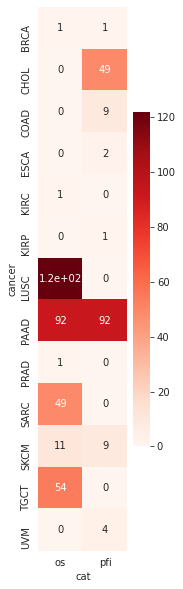

In [35]:
plt.figure(figsize=(2,10))
sns.heatmap(total_plot,cmap="Reds",annot=True)